In [1]:
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
import hdbscan
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pandas as pd

In [2]:
path  = "/nas/home/dkn/Desktop/PyFLEXTRKR_WRF_ref/WRF_test/WRF_test_data/wrf_rainrate_processed/wrfout_rainrate_tb_2014-03-19_01:00:00.nc"
ds = xr.open_dataset(path)
ds = ds.sel(time=ds.time.values[0])  # remove the time axis 
lat = ds['lat'].values
lon = ds['lon'].values
precipitation = ds['pr'].values 

In [3]:
def smooth_precipitation_field(precipitation, sigma=1):
    return gaussian_filter(precipitation, sigma=sigma)

def cluster_with_hdbscan(latitudes, longitudes, precipitation_mask, min_cluster_size):
    """
    Cluster moderate precipitation regions using HDBSCAN.
    """
    lat_points = latitudes[precipitation_mask]
    lon_points = longitudes[precipitation_mask]
    coords = np.column_stack((lat_points, lon_points))

    # HDBSCAN with haversine metric
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='haversine')
    clusterer.fit(np.radians(coords))
    labels = clusterer.labels_

    # Create labeled array
    labeled_array = np.full(precipitation_mask.shape, -1)
    labeled_array[precipitation_mask] = labels + 1  # Add 1 to make labels positive

    return labeled_array

In [11]:
# Step 1: Smooth the precipitation field
precipitation_smooth = smooth_precipitation_field(precipitation, sigma=3)

# Step 2: Create binary mask for moderate precipitation
moderate_threshold = 1  # mm
precipitation_mask = precipitation_smooth >= moderate_threshold

# Step 3: Cluster moderate precipitation points using HDBSCAN
min_cluster_size = 50  # Minimum size of clusters
cluster_selection_epsilon = 100  # km A distance threshold. Clusters below this value will be merged. -> not used
clusters = cluster_with_hdbscan(lat, lon, precipitation_mask, min_cluster_size)

mcs_indices = np.where(clusters > 0)
mcs_lat = lat[mcs_indices]
mcs_lon = lon[mcs_indices]
mcs_prec_values = precipitation[mcs_indices]
mcs_region_labels = clusters[mcs_indices]

df_mcs = pd.DataFrame({
    'lat': mcs_lat,
    'lon': mcs_lon,
    'precip': mcs_prec_values,
    'region_label': mcs_region_labels
})

In [5]:
def plot_precipitation(ax, lon, lat, prec, min_prec_threshold=0.1):
    """
    Plot the precipitation data on the map.

    Parameters:
    - ax: Matplotlib axes object.
    - lon: 2D array of longitudes.
    - lat: 2D array of latitudes.
    - prec: 2D array of precipitation values.
    - min_prec_threshold: Minimum precipitation threshold for masking (mm/hr).
    """

    # Set up the color scheme for precipitation
    cmap = plt.cm.RdYlGn_r  # Radar-like reversed colormap
    levels = [1, 2, 3, 4, 6, 8, 10, 15, 20]
    norm = plt.cm.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

    # Mask precipitation below the threshold
    prec_masked = np.ma.masked_less(prec, min_prec_threshold)

    # Make sure that data below the threshold is white or blue (ocean)
    cmap.set_under('white')
    cmap.set_bad('white')

    # Plot the precipitation data
    precip_plot = ax.pcolormesh(
        lon, lat, prec_masked, cmap=cmap, norm=norm, transform=ccrs.PlateCarree()
    )

    # Create a colorbar
    plt.colorbar(precip_plot, ax=ax, orientation="vertical", label="Precipitation (mm)")

    return precip_plot


def plot_mcs_regions(ax, df_mcs):
    """
    Plot the identified MCS regions on the map.

    Parameters:
    - ax: Matplotlib axes object.
    - df_mcs: DataFrame containing MCS regions with 'lon', 'lat', and 'region_label'.
    """

    # Get unique region labels
    region_labels = df_mcs['region_label'].unique()

    # Define a colormap for regions
    cmap = plt.cm.get_cmap('tab20', len(region_labels))

    # Plot each region with a different color and alpha transparency
    for idx, region_label in enumerate(region_labels):
        region_data = df_mcs[df_mcs['region_label'] == region_label]
        ax.scatter(
            region_data['lon'], region_data['lat'],
            s=0.1, alpha=0.2, color=cmap(idx),
            transform=ccrs.PlateCarree(),
            label=f'Region {int(region_label)}'
        )

def plot_cluster(ax, variable):
    
    clusters_plot = ax.pcolormesh(lon, lat, variable, cmap='tab20', shading='auto')
    plt.colorbar(clusters_plot, ax=ax, label='Cluster Label')
    ax.set_title(f'MCS Clusters')

Text(0.5, 1.0, 'Moderate Precipitation Clusters')

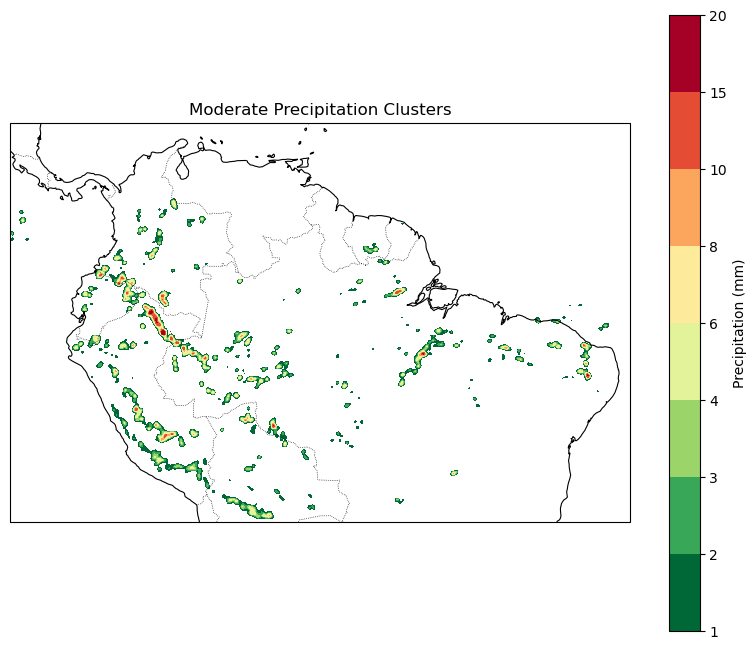

In [12]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# Plot precipitation data
plot_precipitation(ax, lon, lat, precipitation_smooth, min_prec_threshold=0.1)

# Overlay MCS regions
#plot_mcs_regions(ax, df_mcs)

# Add title and legend
ax.set_title('Moderate Precipitation Clusters')


In [7]:
def identify_convective_plumes(precipitation, clusters, heavy_threshold):
    """
    Identify convective plumes within clusters using watershed segmentation.
    """
    convective_plume_labels = np.zeros_like(clusters)
    cluster_labels = np.unique(clusters)
    cluster_labels = cluster_labels[cluster_labels != 0]  # Exclude background

    for label_value in cluster_labels:
        cluster_mask = clusters == label_value
        # Apply heavy precipitation threshold within the cluster
        heavy_mask = np.logical_and(precipitation >= heavy_threshold, cluster_mask)
        if np.any(heavy_mask):
            # Compute the distance transform
            distance = distance_transform_edt(heavy_mask)
            # Find local maxima
            coordinates = peak_local_max(
                distance,
                labels=cluster_mask,
                min_distance=3
            )
            if len(coordinates) == 0:
                continue  # Skip if no peaks are found
            # Create markers array
            markers = np.zeros_like(distance, dtype=int)
            for idx, (row, col) in enumerate(coordinates, start=1):
                markers[row, col] = idx
            # Apply watershed
            labels_ws = watershed(-distance, markers=markers, mask=cluster_mask)
            # Assign unique labels to convective plumes
            labels_ws += convective_plume_labels.max()
            convective_plume_labels += labels_ws

    return convective_plume_labels

def filter_mcs_candidates(clusters, convective_plumes, min_area_km2, min_plumes, grid_cell_area_km2):
    """
    Filter clusters to identify MCS candidates based on area and convective plumes.
    """
    mcs_candidate_labels = []
    cluster_labels = np.unique(clusters)
    cluster_labels = cluster_labels[cluster_labels != 0]

    for label_value in cluster_labels:
        cluster_mask = clusters == label_value
        area_km2 = np.sum(cluster_mask) * grid_cell_area_km2
        plumes_in_cluster = np.unique(convective_plumes[cluster_mask])
        num_plumes = len(plumes_in_cluster[plumes_in_cluster != 0])

        if area_km2 >= min_area_km2 and num_plumes >= min_plumes:
            mcs_candidate_labels.append(label_value)

    return mcs_candidate_labels

In [8]:
# Step 4: Identify convective plumes within clusters
heavy_threshold = 15  # mm
convective_plumes = identify_convective_plumes(precipitation_smooth, clusters, heavy_threshold)

# Step 5: Filter clusters based on area and plume criteria
min_area_km2 = 10000  # Adjust as needed
min_plumes = 2       # Adjust as needed
grid_size = 4  # km
grid_cell_area_km2 = grid_size**2
mcs_candidate_labels = filter_mcs_candidates(clusters, convective_plumes, min_area_km2, min_plumes, grid_cell_area_km2)

# Create final labeled regions for MCS candidates
final_labeled_regions = np.where(np.isin(clusters, mcs_candidate_labels), clusters, 0)

# Prepare detection result
detection_result = {
    'file_path': path,
    'final_labeled_regions': final_labeled_regions,
    'moderate_prec_clusters': clusters,
    'lat': lat,
    'lon': lon,
    'precipitation': precipitation_smooth,
    'time': ds['time'].values,
    'convective_plumes': convective_plumes
}

Text(0.5, 1.0, 'Moderate Precipitation Clusters')

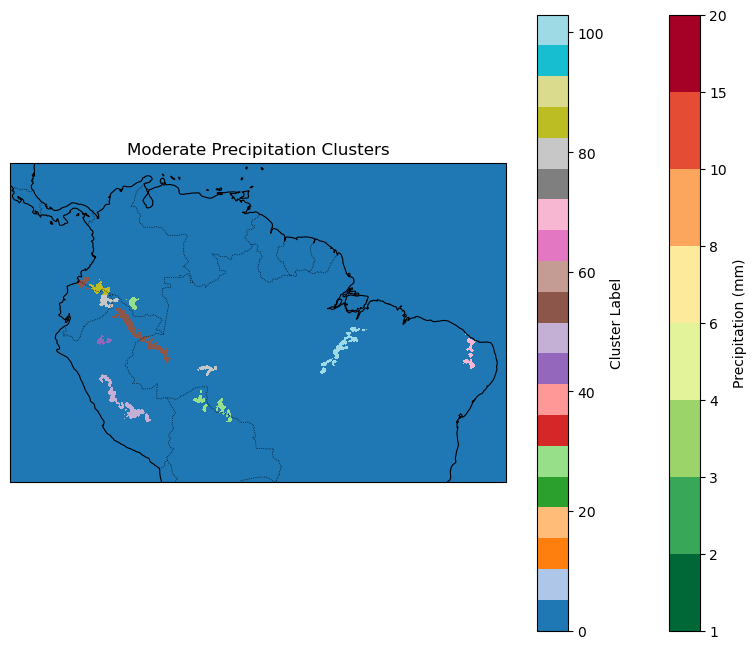

In [9]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# Plot precipitation data
plot_precipitation(ax, lon, lat, precipitation, min_prec_threshold=1)

# Overlay MCS regions
plot_cluster(ax, final_labeled_regions)

# Add title and legend
ax.set_title('Moderate Precipitation Clusters')